[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4628, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.6559, Learning Rate: 0.001
Epoch [20/50], Loss: 0.3261, Learning Rate: 0.001
Epoch [30/50], Loss: 0.0820, Learning Rate: 0.001
Epoch [40/50], Loss: 0.0264, Learning Rate: 0.001
Epoch [50/50], Loss: 0.0383, Learning Rate: 0.001
Mean Absolute Percentage Error (MAPE) for LR=0.001: 1.6388%
R^2 Score for LR=0.001: 0.9970


<ipython-input-1-873e9ad49bfe>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"] = ap_data["Close"].shift(1) * (1 + predicted_return_val / 100)


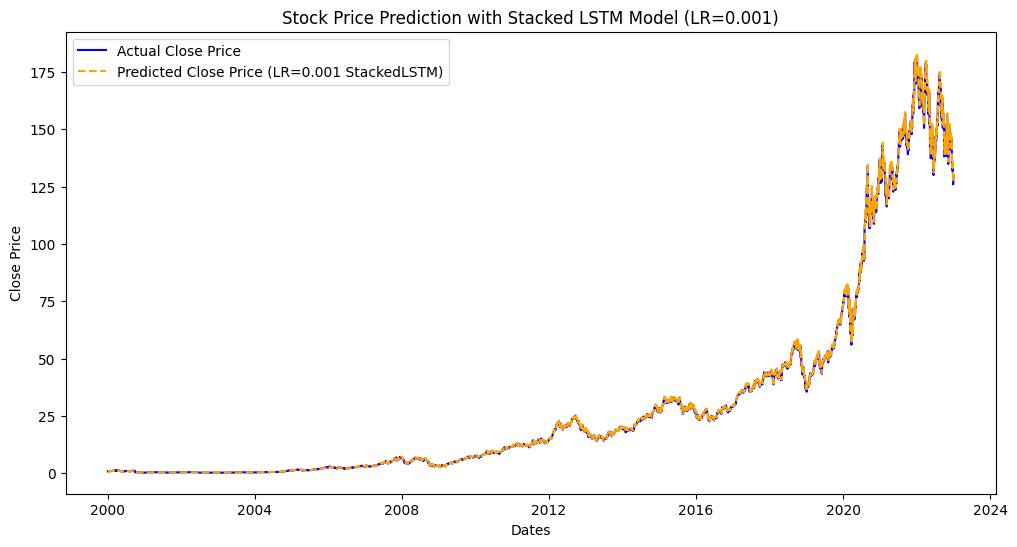

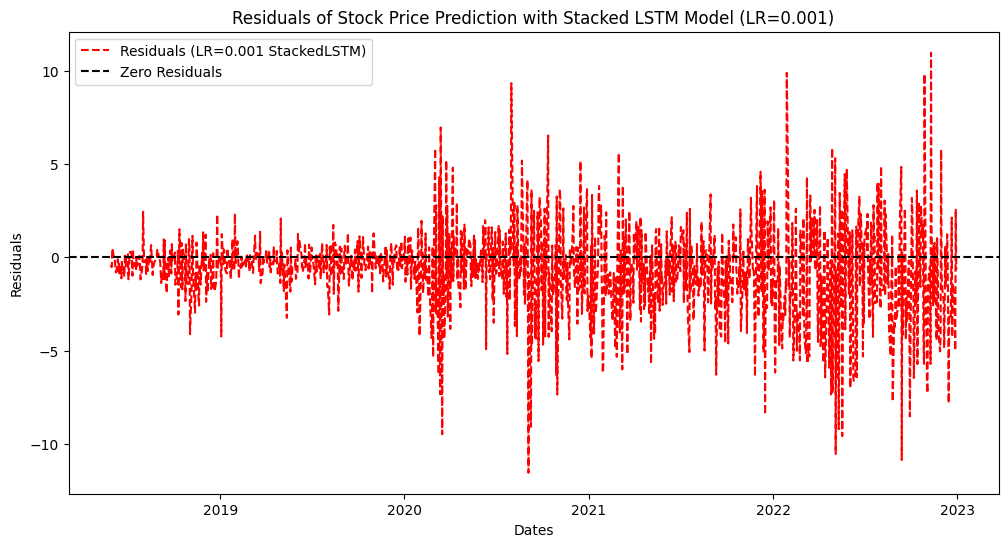

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4628, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.0444, Learning Rate: 0.01
Epoch [20/50], Loss: 0.0337, Learning Rate: 0.01
Epoch [30/50], Loss: 0.0274, Learning Rate: 0.01
Epoch [40/50], Loss: 0.0281, Learning Rate: 0.01
Epoch [50/50], Loss: 0.0285, Learning Rate: 0.01
Mean Absolute Percentage Error (MAPE) for LR=0.01: 1.6460%
R^2 Score for LR=0.01: 0.9970


<ipython-input-1-873e9ad49bfe>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"] = ap_data["Close"].shift(1) * (1 + predicted_return_val / 100)


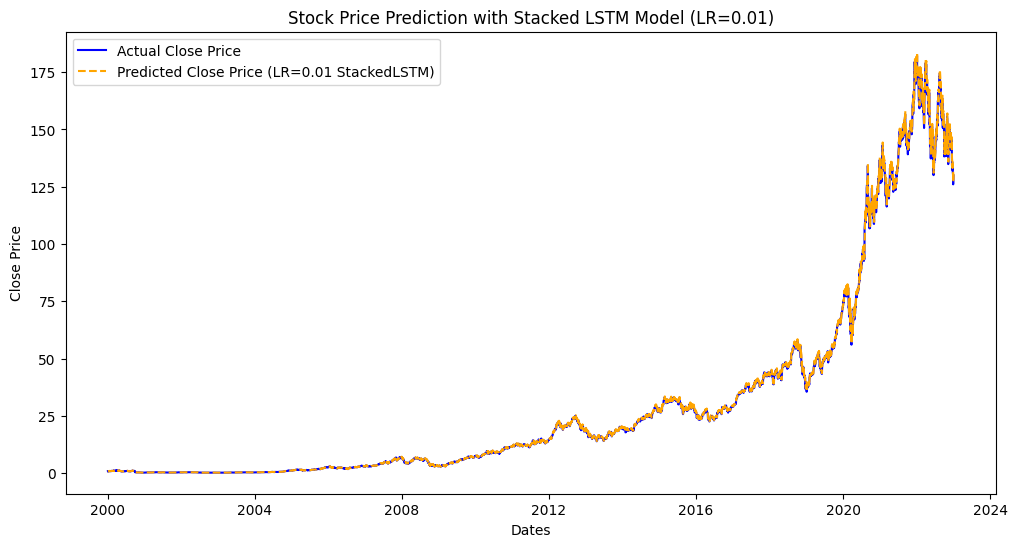

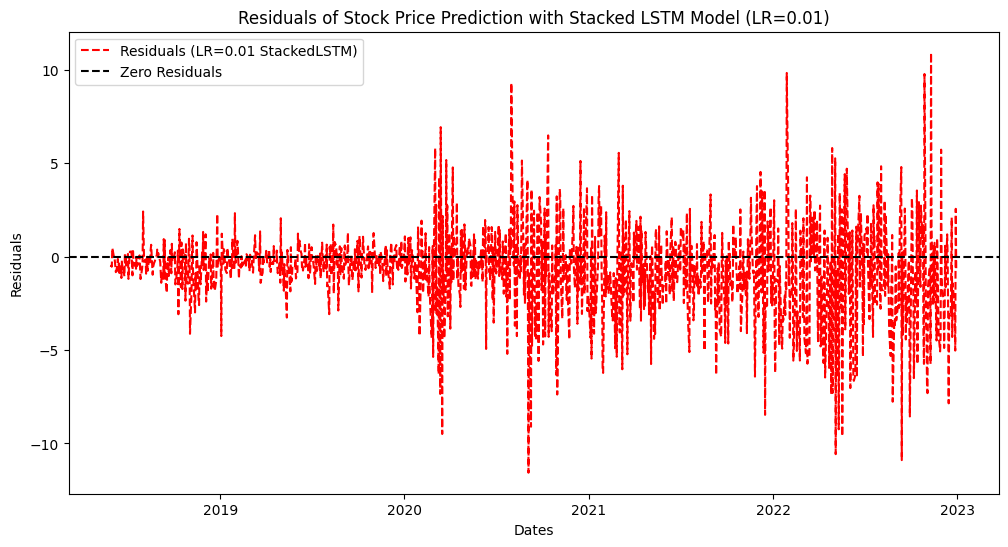

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4628, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.0770, Learning Rate: 0.1
Epoch [20/50], Loss: 0.0357, Learning Rate: 0.1
Epoch [30/50], Loss: 0.0466, Learning Rate: 0.1
Epoch [40/50], Loss: 0.0332, Learning Rate: 0.1
Epoch [50/50], Loss: 0.0402, Learning Rate: 0.1
Mean Absolute Percentage Error (MAPE) for LR=0.1: 1.6530%
R^2 Score for LR=0.1: 0.9970


<ipython-input-1-873e9ad49bfe>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"] = ap_data["Close"].shift(1) * (1 + predicted_return_val / 100)


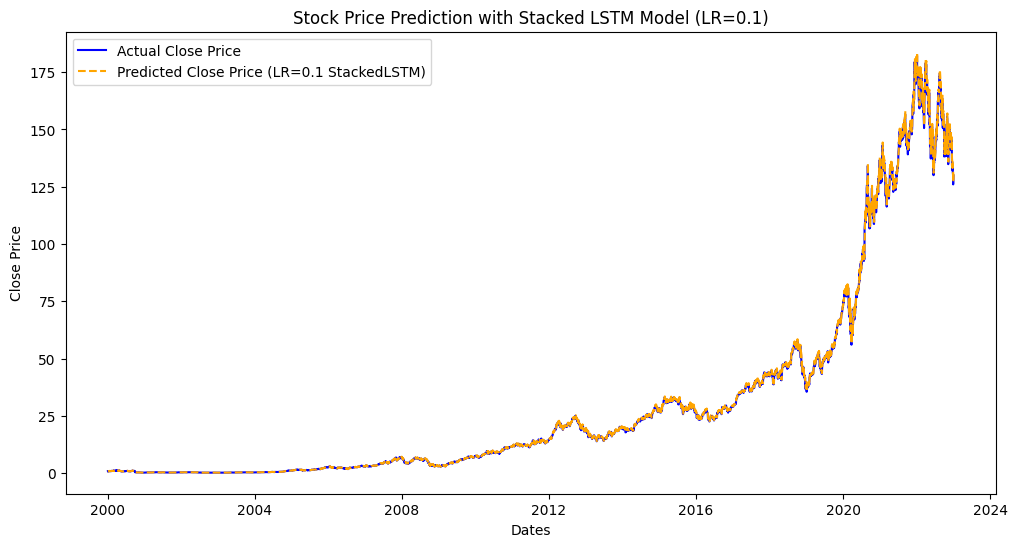

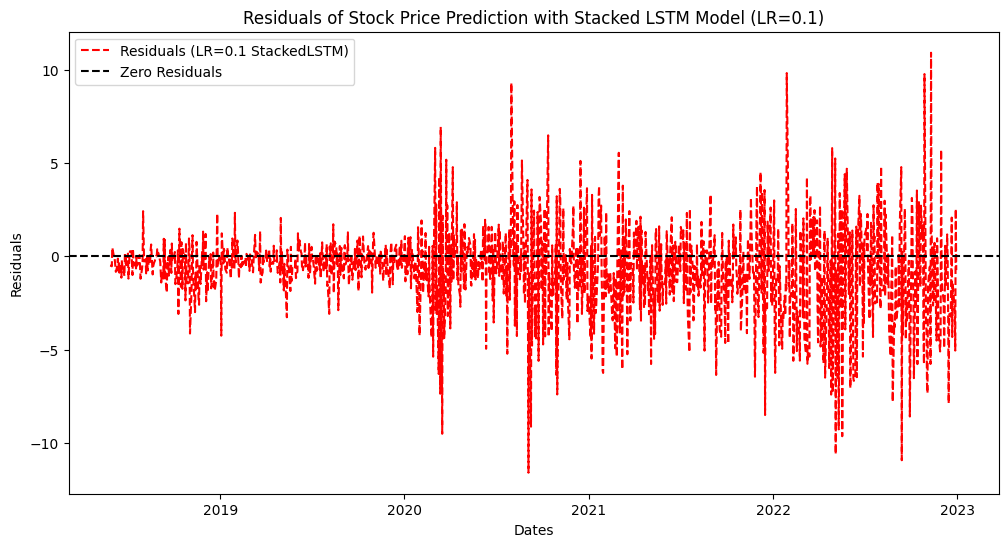

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


ticker = "AAPL"
starting_date = "2000-01-01"
ending_date = "2023-01-01"
ap_data = yf.download(ticker, start=starting_date, end=ending_date)


ap_data["Return"] = ap_data["Close"].pct_change() * 100
ap_data = ap_data.dropna()

features = ap_data["Close"]
targets = ap_data["Return"]

# Split the data into training and testing sets
training_size = int(len(ap_data) * 0.8)
training_feature = features[:training_size].values.reshape(-1, 1)
training_target = targets[:training_size].values.reshape(-1, 1)

testing_feature = features[training_size:].values.reshape(-1, 1)
testing_target = targets[training_size:].values.reshape(-1, 1)

# Normalize data for training
scaler_train = MinMaxScaler()
train_data_feature_normalized = scaler_train.fit_transform(training_feature)

# Normalize data for testing (using the scaler from training)
test_data_feature_normalized = scaler_train.transform(testing_feature)

# Normalize target data for training (using the scaler from training)
train_target_data_normalized = scaler_train.fit_transform(training_target)

# Normalize target data for testing (using the scaler from training)
test_target_data_normalized = scaler_train.transform(testing_target)

# Convert data to PyTorch tensors
train_feature_data_tensor = torch.FloatTensor(train_data_feature_normalized)
test_feature_data_tensor = torch.FloatTensor(test_data_feature_normalized)

train_target_data_tensor = torch.FloatTensor(train_target_data_normalized)
test_target_data_tensor = torch.FloatTensor(test_target_data_normalized)

class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StackedLSTM, self).__init__()
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size if i == 0 else hidden_size, hidden_size, batch_first=True) for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for lstm_layer in self.lstm_layers:
            out, ex = lstm_layer(x)
            x = out  # Pass the output to the next layer

        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1  # Only Rate of Return
hidden_sizes = 32
output_size = 1  # Predicted Rate of Return
no_layers = 4  # Number of LSTM layers
epochs = 50
learn_rates = [0.001, 0.01, 0.1]

# Initialize lists to store results
losses = []
mapes_val = []
r2_scores_val = []

# Plot the results and residuals for each learning rate
for lr in learn_rates:
    # Model, loss function, and optimizer
    model_LSTM = StackedLSTM(input_size, hidden_sizes, output_size, no_layers)
    criterion_loss = nn.L1Loss()
    optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=lr)

    # Training the model
    for ep in range(epochs):
        inputs_val = train_feature_data_tensor.unsqueeze(0)
        targets_val = train_target_data_tensor

        outputs_val = model_LSTM(inputs_val)
        loss = criterion_loss(outputs_val, targets_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (ep + 1) % 10 == 0:
            print(f'Epoch [{ep+1}/{epochs}], Loss: {loss.item():.4f}, Learning Rate: {lr}')

    # Testing the model
    model_LSTM.eval()
    with torch.no_grad():
        test_input_val = test_feature_data_tensor.unsqueeze(0)
        predicted_outputs = model_LSTM(test_input_val)   # going to give the rate of return

    # Convert rate of return back to prices
    predicted_return_val = predicted_outputs[0, 0].item()
    ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"] = ap_data["Close"].shift(1) * (1 + predicted_return_val / 100)

    # Calculate MAPE
    actual_val = ap_data["Close"].iloc[training_size:]
    predicted_val = ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"].iloc[training_size:]
    mape = np.mean(np.abs((actual_val - predicted_val) / actual_val)) * 100
    print(f"Mean Absolute Percentage Error (MAPE) for LR={lr}: {mape:.4f}%")
    mapes_val.append(mape)

    # Calculate R2 Score
    r2 = r2_score(actual_val, predicted_val)
    print(f"R^2 Score for LR={lr}: {r2:.4f}")
    r2_scores_val.append(r2)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(ap_data.index, ap_data["Close"], label="Actual Close Price", color='blue')
    plt.plot(ap_data.index, ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"], label=f"Predicted Close Price (LR={lr} StackedLSTM)", linestyle="--", color='orange')
    plt.title(f"Stock Price Prediction with Stacked LSTM Model (LR={lr})")
    plt.xlabel("Dates")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

    # Plot the residuals
    plt.figure(figsize=(12, 6))
    residuals = ap_data["Close"].iloc[training_size:] - ap_data[f"Predicted_Return_LR_{lr}_StackedLSTM"].iloc[training_size:]
    plt.plot(ap_data.index[training_size:], residuals, label=f"Residuals (LR={lr} StackedLSTM)", linestyle="--", color='red')
    plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
    plt.title(f"Residuals of Stock Price Prediction with Stacked LSTM Model (LR={lr})")
    plt.xlabel("Dates")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()
